In [91]:
# Modues to be used
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import json

from re import sub
import ast 

from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score

import pickle

# Global variables
MASTER_CSV_PATH = '~/Desktop/csgo-csv/'

In [88]:
## READ DATE FROM MASTER ##

# Read the data from all years
# year_vec = ['2012','2013','2014','2015','2016','2017','2018','2019']

year_vec = ['2019']

# Empty data frames
df_player = pd.DataFrame( { } )
df_team   = pd.DataFrame( { } )

df_event = pd.read_csv(MASTER_CSV_PATH+'events.csv')
df_event = df_event.set_index('id')

# Append the data from each year
for year in year_vec:
        
    file_name = MASTER_CSV_PATH + year + '-player-lvl.csv'
    df_player = df_player.append( pd.read_csv( file_name ), ignore_index=True, sort=False )
    
    file_name = MASTER_CSV_PATH + year + '-team-lvl.csv'
    df_team   = df_team.append( pd.read_csv( file_name ), ignore_index=True, sort=False )

In [4]:
# Extracting the relevant data

# Maping from a map_id to an event
map_to_event_dic = {}

for map_id in df_team.map_id.unique():
    event_id = df_team[ df_team['map_id']==map_id ]['event_id'].unique()[0]
    map_to_event_dic[map_id] = event_id

# Player's relevant stats:
# -> Dictionary that has the players relevant statistics

# Initialize the dictionary entries
player_aux_dic = {}

for player_id in df_player.player_id.unique():
    player_aux_dic[player_id]                 = {}
    player_aux_dic[player_id]['prize_money']  = float( 0.0 )
    player_aux_dic[player_id]['prize_rating'] = float( 0.0 )
    player_aux_dic[player_id]['rating']       = float( 0.0 )

    player_aux_dic[player_id]['map_count']   = 0
    player_aux_dic[player_id]['name']        = df_player[ df_player['player_id']==player_id ]['player_name'].unique()[0]

print('Dictionary initialized')

# Collect the prize money earned by each player:
# -> Here we assume that the prize is divided by 6 (players+coach) evenly
for event_id in df_team['event_id'].unique():

    try:
        # The prize distribution is a string that we convert to a dictionary
        s   = df_event.loc[event_id]['prizeDistribution']
        l   = len(s)
        dic = ast.literal_eval(s[1:l-1])
        
        # Loop through each of the places of the tournament
        for place in dic:
            try:
                prize   = float(sub(r'[^\d.]', '', place['prize']))
                team_id = place['team']['id']

                map_id_vec = df_team[ (df_team['event_id']==event_id) & (df_team['team_id']==team_id) ]['map_id'].unique()

                # Assuming the prize gets divided evenlty between players and coach 
                for player_id in df_player[ (df_player['map_id']==map_id_vec[0]) & (df_player['team_id']==team_id) ].player_id.values:
                    player_aux_dic[player_id]['prize_money'] = player_aux_dic[player_id]['prize_money'] + prize / 6.0

            except:
                continue 

    except:
        continue  
      
print('Prize money collected')

# Now we compute the global rating, including tournaments with no prize money
for map_id in df_team['map_id'].unique():

    # Get a DataFrame with the players that participated in this map
    df_tmp = df_player[ df_player['map_id']==map_id ]

    # Get a sum of all the rating for each player together with a count of the maps played
    for player_id in df_tmp['player_id'].unique():
        rating = df_tmp[ df_tmp['player_id']==player_id ]['rating'].values[0]
        player_aux_dic[player_id]['rating']    = player_aux_dic[player_id]['rating'] + rating
        player_aux_dic[player_id]['map_count'] = player_aux_dic[player_id]['map_count'] + 1

print('Rating for all players collected')

# Now we do some operations on the stats we have
for player_id in df_player.player_id.unique():
    
    # Compute the prize rating
    if player_aux_dic[player_id]['prize_money'] > 0.0:
        player_aux_dic[player_id]['prize_rating'] = np.log( player_aux_dic[player_id]['prize_money'] ) / 12.0
    else:
        player_aux_dic[player_id]['prize_rating'] = 0.0

    # Get the average rating
    if player_aux_dic[player_id]['map_count'] > 0:
        player_aux_dic[player_id]['rating'] = player_aux_dic[player_id]['rating'] / float(player_aux_dic[player_id]['map_count'])
        
print('Normalized ratings')

Dictionary initialized
Prize money collected
Rating for all players collected
Normalized ratings


In [53]:
# Now we do some operations on the stats we have
for player_id in df_player.player_id.unique():
    
    # Compute the prize rating
    if player_aux_dic[player_id]['prize_money'] > 0.0:
        player_aux_dic[player_id]['prize_rating'] = np.log( player_aux_dic[player_id]['prize_money'] ) / 12.0
        # player_aux_dic[player_id]['prize_rating'] = player_aux_dic[player_id]['prize_money']
    else:
        player_aux_dic[player_id]['prize_rating'] = 0.0

## Problem with the features:
If we take the individual player features, then the order on which we put the players affect.

- We need features that take into account that all players are treated equally 

In [54]:
# For this example, we take as features:
# (1) Avg. Rating T1, Avg Rating T2
# (2) Avg. Prize_rating T1, Avg. Prize_rating T1 

# Create the feature DataFrame for training/testing
data_dic = {}

for map_id in df_team['map_id'].unique():

    data_dic[map_id] = {}

    df_tmp = df_player[ df_player['map_id']==map_id ]

    # Scores
    t1_id = df_tmp['team_id'].unique()[0]
    t2_id = df_tmp['team_id'].unique()[1]
    
    t1_score = df_team[ (df_team['team_id']==t1_id) & (df_team['map_id']==map_id) ]['team_score'].values[0]
    t2_score = df_team[ (df_team['team_id']==t2_id) & (df_team['map_id']==map_id) ]['team_score'].values[0]

    df_t1 = df_tmp[ df_tmp['team_id']==t1_id ]
    df_t2 = df_tmp[ df_tmp['team_id']==t2_id ]

    # We rank two teams in terms of their prize pool    
    rating_t1 = float(0.0)   
    prize_t1  = float(0.0) 
    count     = 0
    for ind in df_t1.index:

        player_id = df_t1.loc[ind].player_id

        count = count + 1
        
        rating_t1 = rating_t1 + player_aux_dic[player_id]['rating']
        prize_t1  = prize_t1  + player_aux_dic[player_id]['prize_rating']       

    # For the second team
    rating_t2 = float(0.0)   
    prize_t2  = float(0.0) 
    count     = 0
    for ind in df_t2.index:

        player_id = df_t2.loc[ind].player_id

        count = count + 1
        
        rating_t2 = rating_t2 + player_aux_dic[player_id]['rating']
        prize_t2  = prize_t2  + player_aux_dic[player_id]['prize_rating']       

    
    # Check if we need to change the order
    if prize_t1 > prize_t2:

        if t1_score > t2_score:
            data_dic[map_id]['fav_win'] = 1
        else:
            data_dic[map_id]['fav_win'] = 0

        data_dic[map_id]['rating_fav'] = {}
        data_dic[map_id]['rating_fav'] = rating_t1 / float(count)

        data_dic[map_id]['prize_fav'] = {}
        data_dic[map_id]['prize_fav'] = prize_t1 / float(count)

        data_dic[map_id]['rating_op'] = {}
        data_dic[map_id]['rating_op'] = rating_t2 / float(count)

        data_dic[map_id]['prize_op'] = {}
        data_dic[map_id]['prize_op'] = prize_t2 / float(count)

    else:

        if t1_score > t2_score:
            data_dic[map_id]['fav_win'] = 0
        else:
            data_dic[map_id]['fav_win'] = 1

        data_dic[map_id]['rating_fav'] = {}
        data_dic[map_id]['rating_fav'] = rating_t2 / float(count)

        data_dic[map_id]['prize_fav'] = {}
        data_dic[map_id]['prize_fav'] = prize_t2 / float(count)

        data_dic[map_id]['rating_op'] = {}
        data_dic[map_id]['rating_op'] = rating_t1 / float(count)

        data_dic[map_id]['prize_op'] = {}
        data_dic[map_id]['prize_op'] = prize_t1 / float(count)

       


data = pd.DataFrame.from_dict(data_dic,orient='index')
data.to_csv('data/training_v2.csv')

In [97]:
#data[:60]
#data.loc('7992')
#df_team.head()

fav_win  rating_fav  prize_fav  rating_op  prize_op
79922        1    1.059284   0.774578   1.022417  0.621190
79923        1    1.059284   0.774578   1.022417  0.621190
79924        1    1.032377   0.257762   0.774897  0.000000
79925        0    0.953853   0.335480   1.140916  0.271259
79926        1    0.927699   0.271541   1.046583  0.121158
79927        0    0.955307   0.411039   1.062400  0.087051
79928        1    1.046583   0.121158   0.774897  0.000000
79930        0    1.069953   0.678618   0.914967  0.530826
79931        1    0.955307   0.411039   0.953853  0.335480
79932        1    1.046583   0.121158   0.774897  0.000000
79933        0    0.955307   0.411039   0.953853  0.335480
79934        1    1.069953   0.678618   0.914967  0.530826
79935        1    0.955307   0.411039   0.953853  0.335480
79937        1    1.069953   0.678618   0.914967  0.530826
79938        1    1.047941   0.696346   1.041526  0.629912
79939        1    0.927699   0.271541   1.032377  0.257762
79942        1    1.047941   0.696346   1.041526  0.629912
79943        1    1.047941   0.696346   1.069953  0.678618
79944        0    1.140916   0.271259   1.062400  0.087051
79945        0    1.047941   0.696346   1.069953  0.678618
79946        0    1.032377   0.257762   1.046583  0.121158
79947        0    1.047941   0.696346   1.069953  0.678618
79948        1    1.032377   0.257762   1.046583  0.121158
79949        1    1.032377   0.257762   1.046583  0.121158
79952        0    0.955307   0.411039   1.140916  0.271259
79953        0    0.955307   0.411039   1.140916  0.271259
79954        0    1.032377   0.257762   1.062400  0.087051
79955        1    1.032377   0.257762   1.062400  0.087051
79956        1    1.032377   0.257762   1.062400  0.087051
79957        0    0.927699   0.271541   1.140916  0.271259
79958        0    0.927699   0.271541   1.140916  0.271259
79959        1    1.061486   0.892349   0.994033  0.668800
79960        0    1.061456   0.643310   1.059520  0.630991
79961        1    1.140916   0.271259   1.032377  0.257762
79962        1    1.061486   0.892349   0.994033  0.668800
79963        1    1.061456   0.643310   1.059520  0.630991
79964        1    1.140916   0.271259   1.032377  0.257762
79965        1    1.049114   0.778257   1.027060  0.652530
79966        0    1.049114   0.778257   1.027060  0.652530
79967        0    1.061456   0.643310   1.059520  0.630991
79968        0    1.097199   0.833836   0.944056  0.551188
79970        1    1.061486   0.892349   0.971544  0.623462
79971        0    1.059284   0.774578   1.033868  0.679240
79972        0    1.081673   0.743252   0.994033  0.668800
79973        1    1.081673   0.743252   0.994033  0.668800
79974        1    1.134909   0.893291   0.991021  0.679298
79975        1    1.140454   0.894274   1.056914  0.315873
79976        0    1.067669   0.708847   1.027060  0.652530
79977        1    1.113423   0.985158   1.058984  0.577581
79978        1    1.069035   0.746039   1.056573  0.661400
79979        1    1.019105   0.679691   1.079693  0.659640
79980        1    0.981875   0.630547   1.055667  0.477851
79981        1    1.140454   0.894274   1.056914  0.315873
79982        0    1.024484   0.574191   1.042287  0.497654
79984        1    1.134909   0.893291   0.991021  0.679298
79985        0    1.019105   0.679691   1.079693  0.659640
79986        1    1.113423   0.985158   1.058984  0.577581
79987        0    0.981875   0.630547   1.055667  0.477851
79988        1    1.069035   0.746039   1.056573  0.661400
79990        1    1.024484   0.574191   1.042287  0.497654

# Classification report in the Logistic Model

The function 'classification_report' from sklearn produces a string output that incudes:
- Precision: Ratio tp/(tp+fp) where tp is the number of true positives and fp is the number of false possitives.
    - Intuitively: Ability of the classifier not to label as positive a sample that is negative.
- Recall: Ratio tp/(tp+fn) where tp is the number of true positives and fn is the number of false negatives. 
    - Intuitively: Ability of the classifier to find all the positive samples
- F1-score: Balanced F-score or F-measure 2*(precision*recall)/(precision+recall)
    - Intuitively: Weighted average of the precision and recall. The closer to 1 the better


Documentation: 
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support

In [108]:
#data

In [125]:
# Divide data set into training and testing sets
# -> We use 75% of the data for training and 25% for testing
X_train, X_test, y_train, y_test = train_test_split(data.drop('fav_win',axis=1),data['fav_win'], test_size=0.25)

# Make an instance of the model, and increase the maximum number of iterations to avoid convergence problems
logmodel = LogisticRegression(max_iter=500)

X_train

# Training for the model
logmodel.fit(X_train,y_train)

# Now we use the testing data set to make predictions and evaluate the model's performance
predictions = logmodel.predict(X_test)

print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))

print(confusion_matrix(y_test.values, predictions))


#df = pd.DataFrame(y_test.values,predictions,columns=['real','prediction'])

print(y_test.values[:50])
print(predictions[:50])

print(y_test.values[:5] == predictions[:5])
sum(y_test.values[:] == predictions[:]) / float(len(predictions))
# filename = 'model_jan23.sav'
#pickle.dump( logmodel, open(filename,'wb') )

# R^2 score might not be a good value since it's for linear regression
# r2_score(y_test.values,predictions)


>               precision    recall  f1-score   support

Underdog wins       0.54      0.12      0.20      1276
Favorite wins       0.69      0.95      0.80      2586

     accuracy                           0.68      3862
    macro avg       0.62      0.54      0.50      3862
 weighted avg       0.64      0.68      0.60      3862

[[ 152 1124]
 [ 127 2459]]
[0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 1
 0 1 1 0 1 0 1 1 1 1 1 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1]
[False False  True  True  True]


0.6760745727602279

In [104]:
print( logmodel.coef_ )
print( logmodel.classes_ )
print( logmodel.intercept_ )
X_test

[[ 5.73601455  2.50600942 -6.1899147  -2.08351566]]
[0 1]
[0.339295]


rating_fav  prize_fav  rating_op  prize_op
82867    1.034417   0.606879   1.035329  0.571893
80392    0.994033   0.668800   0.933326  0.667483
80467    1.060773   0.955344   1.051812  0.829291
86677    1.037485   0.601709   0.998449  0.133384
87312    1.069951   0.644671   0.633630  0.000000
...           ...        ...        ...       ...
96728    1.148064   0.860256   1.051981  0.614542
95090    1.079345   0.660918   1.148058  0.657069
81150    1.112695   0.919067   1.081673  0.743252
94430    1.175157   1.066097   1.068869  0.800433
95225    1.136858   0.914914   1.045384  0.654437

[3862 rows x 4 columns]

In [40]:
# Test to see if the money rating helps or not
# -> Let's drop the money
data_no_money = data.drop(['prize_fav','prize_op'],axis=1)

# data_no_money.head()

# Divide data set into training and testing sets
# -> We use 75% of the data for training and 25% for testing
X_train, X_test, y_train, y_test = train_test_split(data_no_money.drop('fav_win',axis=1),data_no_money['fav_win'], test_size=0.25)

# Make an instance of the model, and increase the maximum number of iterations to avoid convergence problems
logmodel = LogisticRegression(max_iter=500)

X_train

# Training for the model
logmodel.fit(X_train,y_train)

# Now we use the testing data set to make predictions and evaluate the model's performance
predictions = logmodel.predict(X_test)

print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))

print( logmodel.coef_ )
print( logmodel.classes_ )
print( logmodel.intercept_ )

confusion_matrix(y_test.values, predictions)


>               precision    recall  f1-score   support

Underdog wins       0.57      0.10      0.18      1271
Favorite wins       0.69      0.96      0.80      2591

     accuracy                           0.68      3862
    macro avg       0.63      0.53      0.49      3862
 weighted avg       0.65      0.68      0.60      3862

[[ 7.19262414 -7.69095631]]
[0 1]
[0.9294035]


array([[ 133, 1138],
       [ 101, 2490]])

In [127]:
# Save the player features
team_id_vec = [
    6665,4494,5973,4991,10399,9565,8474,4608,6667,5995,
    4411,4869,8135,9215,8297,7175,5752,8362,5378    # Missing c0ntact since we have no data
    ]
team_name_vec = []

dic_team = {}
dic_team_players = {}

df_player = df_player.sort_values(by='date',ascending=False)

dic_players={}

for ind in range(0,len(team_id_vec)):
    dic_team[team_id_vec[ind]] = {}
    dic_team[team_id_vec[ind]]['team_name'] = df_team[df_team['team_id']==team_id_vec[ind]].team_name.unique()[0]
    
    dic_team_players[team_id_vec[ind]] = {}
    #dic_team_players[team_id_vec[ind]]['player_id'] = {}
    #dic_team_players[team_id_vec[ind]]['player_name'] = {}
    for ind2 in range(0,5):        
        player_id = str(df_player[df_player['team_id']==team_id_vec[ind]].player_id.unique()[ind2])
        dic_team_players[team_id_vec[ind]][player_id] = {}
        dic_team_players[team_id_vec[ind]][player_id]['name'] = {}
        dic_team_players[team_id_vec[ind]][player_id]['name'] = str(df_player[df_player['team_id']==team_id_vec[ind]].player_name.unique()[ind2])

        dic_players[player_id] = {}
        dic_players[player_id]['name'] = str(df_player[df_player['team_id']==team_id_vec[ind]].player_name.unique()[ind2])

        player_id_num = df_player[df_player['team_id']==team_id_vec[ind]].player_id.unique()[ind2]
        dic_players[player_id]['rating']       = str( player_aux_dic[player_id_num]['rating'] )
        dic_players[player_id]['prize_rating'] = str( player_aux_dic[player_id_num]['prize_rating'] )
        
        # dic_team_players[team_id_vec[ind]]['player_id'][ind2]   = str(df_player[df_player['team_id']==team_id_vec[ind]].player_id.unique()[ind2])
        # dic_team_players[team_id_vec[ind]]['player_name'][ind2] = str(df_player[df_player['team_id']==team_id_vec[ind]].player_name.unique()[ind2])

team_name_vec
#df = pd.Dataframe(  )
dic_team


df_player.head()

#df_player[df_player['team_id']==team_id_vec[0]].player_id.unique()
#df_player[df_player['team_id']==team_id_vec[0]]
#len(df_player)
dic_team_players

json_tmp = json.dumps(dic_team)
f = open("dict_team.json","w")
f.write(json_tmp)
f.close()

json_tmp = json.dumps(dic_team_players)
f = open("dict_team_players.json","w")
f.write(json_tmp)
f.close()

json_tmp = json.dumps(dic_players)
f = open("dict_players.json","w")
f.write(json_tmp)
f.close()

In [99]:
player_aux_dic

10283: {'prize_money': 5000.0,
  'prize_rating': 0.7097660992846865,
  'rating': 1.1506666666666665,
  'map_count': 15,
  'name': 'Ant1ka'},
 16897: {'prize_money': 24.166666666666668,
  'prize_rating': 0.26541452276604327,
  'rating': 0.951875,
  'map_count': 16,
  'name': 'riv'},
 10285: {'prize_money': 5000.0,
  'prize_rating': 0.7097660992846865,
  'rating': 1.1953333333333336,
  'map_count': 15,
  'name': 't4tty'},
 7642: {'prize_money': 0.0,
  'prize_rating': 0.0,
  'rating': 0.8766666666666666,
  'map_count': 6,
  'name': 'Cla'},
 7810: {'prize_money': 11208.333333333332,
  'prize_rating': 0.7770344023530025,
  'rating': 1.0636697247706421,
  'map_count': 109,
  'name': 'ShahZaM'},
 8633: {'prize_money': 23596.5,
  'prize_rating': 0.8390711395775557,
  'rating': 1.2472916666666662,
  'map_count': 48,
  'name': 'di^'},
 13054: {'prize_money': 3834.166666666667,
  'prize_rating': 0.6876422827801262,
  'rating': 1.1457407407407405,
  'map_count': 162,
  'name': 'zeph'},
 2007: {'pr

In [68]:
#print(player_aux_dic)
#print(prize)

df_money = pd.DataFrame.from_dict(player_aux_dic,orient='index',)
df_money = df_money.sort_values(['prize_money','rating'],ascending=False)

df_money[:60]


prize_money  prize_rating    rating  map_count         name
7592   359750.000000      1.066097  1.266101        159       device
9032   359750.000000      1.066097  1.199623        159       Magisk
7398   359750.000000      1.066097  1.155220        159      dupreeh
4954   359750.000000      1.066097  1.153648        159        Xyp9x
7412   359750.000000      1.066097  1.101195        159       gla1ve
8797   232041.666667      1.029556  1.106953        233     Stewie2K
8738   231541.666667      1.029376  1.242018        223        EliGE
8520   231541.666667      1.029376  1.213964        222          NAF
10394  231541.666667      1.029376  1.172511        223      Twistzz
7687   231541.666667      1.029376  1.076968        221        nitr0
9960   149085.833333      0.992690  1.191884        276       frozen
11893  148514.166667      0.992370  1.347934        271        ZywOo
7322   148514.166667      0.992370  1.065646        271         apEX
8184   148514.166667      0.992370  1.034354        271         ALEX
7169   148514.166667      0.992370  1.026494        271          RpK
429    146333.333333      0.991137  0.983211        218     karrigan
11816  145500.000000      0.990661  1.215700        200         ropz
2730   145500.000000      0.990661  1.059851        202       chrisJ
10671  145000.000000      0.990374  1.165913        230        Ethan
11219  145000.000000      0.990374  1.157293        229         CeRq
8574   139208.333333      0.986977  1.190050        201        woxic
8523   138541.666667      0.986577  1.060968        217        tarik
9136   138333.333333      0.986452  1.208578        225       Brehze
11916  117590.166667      0.972913  1.142743        175       sergej
695    117590.166667      0.972913  1.133103        174         allu
4076   117590.166667      0.972913  1.070632        174       Aerial
7248   117590.166667      0.972913  1.008391        174       xseveN
8507   114625.000000      0.970785  1.019175        206    stanislaw
11343  113344.500000      0.969849  1.129137        278        SHiPZ
1225   105882.500000      0.964174  1.099452        219         shox
334    103347.000000      0.962154  0.970691        217        AdreN
7834   100333.333333      0.959688  1.000000        233       v1c7oR
2799    99583.333333      0.959063  0.986494        251       bubble
8183    98333.333333      0.958010  1.087600        175         rain
885     98333.333333      0.958010  1.043543        175  olofmeister
12126   97833.333333      0.957585  1.191195        251       poizon
3741    97500.000000      0.957301  1.172294        170         NiKo
10697   97355.833333      0.957177  1.054906        212      blocker
7168    96347.500000      0.956310  1.092687        227         NBK-
9816    95006.833333      0.955142  1.023286        140      Aleksib
7167    91799.166667      0.952280  1.174960        252       kennyS
284     91799.166667      0.952280  1.087729        251        JaCkz
13666   90791.666667      0.951360  1.136019        206      Brollan
7528    90791.666667      0.951360  1.117398        196        KRIMZ
3849    90791.666667      0.951360  1.083073        205           JW
7998    89000.000000      0.949699  1.316383        141       s1mple
8918    89000.000000      0.949699  1.231583        139   electronic
7594    89000.000000      0.949699  1.075180        139       flamie
13776   84805.333333      0.945676  1.284477        306         Jame
13239   84805.333333      0.945676  1.145738        305       qikert
11942   84805.333333      0.945676  1.112492        305       buster
2757    80416.666667      0.941248  1.029739        153     GuardiaN
12553   78396.333333      0.939128  1.202632        285       yuurih
15631   77771.333333      0.938461  1.209649        285     KSCERATO
12521   77771.333333      0.938461  1.111544        285          arT
12822   77563.000000      0.938237  1.045901        283         VINI
9616    73674.166667      0.933951  1.063048        210       AmaNEk
8564   

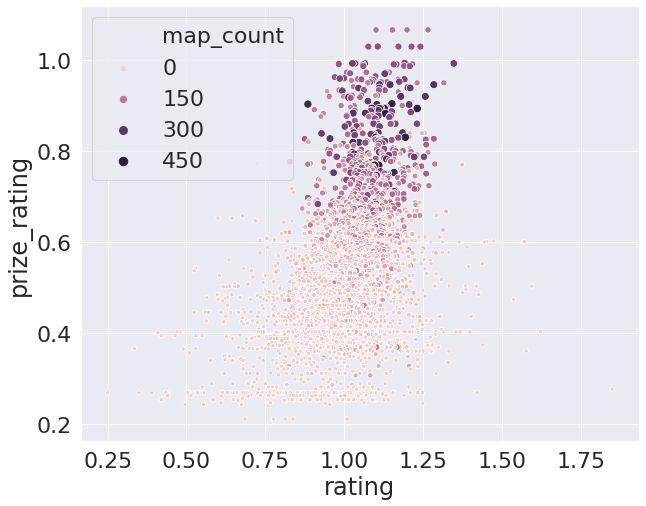

In [69]:
sns.set_style("whitegrid")
sns.set(font_scale=2)

df_tmp = df_money[ df_money['prize_money']>np.log(3000) /12]
plt.figure(figsize=(10,8));

sns.scatterplot(data=df_tmp,x='rating',y='prize_rating',size='map_count',hue='map_count');

In [81]:
X = pd.DataFrame.as_matrix(df_tmp,columns=['rating','prize_rating'])
#X = pd.DataFrame.as_matrix(df_tmp,columns=['prize_rating'])
#X = df_tmp.values(columns=['rating','prize_money'])
#X = df_tmp.values(columns=['prize_rating'])
#
kmeans = KMeans(n_clusters=15, random_state=0).fit(X)
#df_tmp.sort_values('rating',ascending=False)[:30]

#Z = df_tmp.index.values

df_tmp['label'] = kmeans.labels_

/home/emmanuel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/emmanuel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


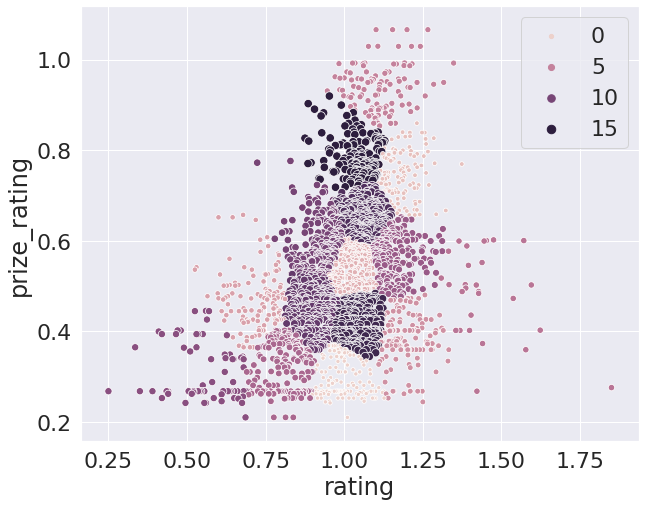

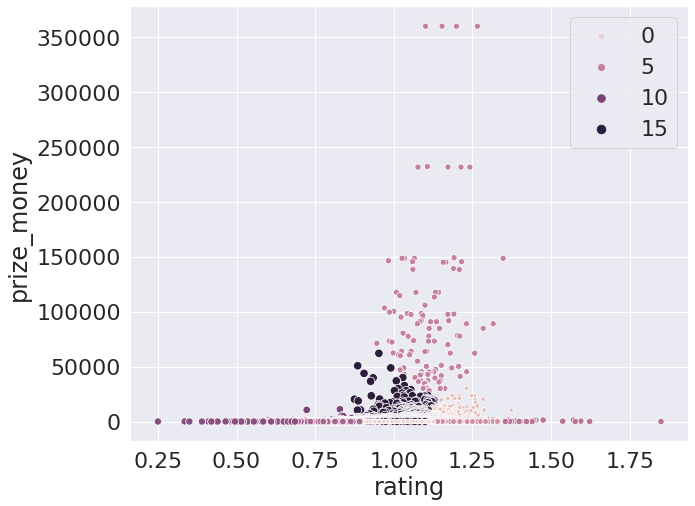

In [82]:
plt.figure(figsize=(10,8));
sns.scatterplot(data=df_tmp,x='rating',y='prize_rating',hue=kmeans.labels_,size=kmeans.labels_);
plt.figure(figsize=(10,8));
sns.scatterplot(data=df_tmp,x='rating',y='prize_money',hue=kmeans.labels_,size=kmeans.labels_);


In [75]:
df_tmp[:60]
df_tmp[(df_tmp['label']==2) | (df_tmp['label']==1)].sort_values(['prize_money','rating'],ascending=False)[:60]

prize_money  prize_rating    rating  map_count      name  label
7592   359750.000000      1.066097  1.266101        159    device      2
9032   359750.000000      1.066097  1.199623        159    Magisk      2
7398   359750.000000      1.066097  1.155220        159   dupreeh      2
4954   359750.000000      1.066097  1.153648        159     Xyp9x      2
7412   359750.000000      1.066097  1.101195        159    gla1ve      2
8797   232041.666667      1.029556  1.106953        233  Stewie2K      1
8738   231541.666667      1.029376  1.242018        223     EliGE      1
8520   231541.666667      1.029376  1.213964        222       NAF      1
10394  231541.666667      1.029376  1.172511        223   Twistzz      1
7687   231541.666667      1.029376  1.076968        221     nitr0      1
9960   149085.833333      0.992690  1.191884        276    frozen      1
11893  148514.166667      0.992370  1.347934        271     ZywOo      1
7322   148514.166667      0.992370  1.065646        271      apEX      1
8184   148514.166667      0.992370  1.034354        271      ALEX      1
7169   148514.166667      0.992370  1.026494        271       RpK      1
429    146333.333333      0.991137  0.983211        218  karrigan      1
11816  145500.000000      0.990661  1.215700        200      ropz      1
2730   145500.000000      0.990661  1.059851        202    chrisJ      1
10671  145000.000000      0.990374  1.165913        230     Ethan      1
11219  145000.000000      0.990374  1.157293        229      CeRq      1
8574   139208.333333      0.986977  1.190050        201     woxic      1
8523   138541.666667      0.986577  1.060968        217     tarik      1
9136   138333.333333      0.986452  1.208578        225    Brehze      1